In [ ]:
#@title Setup Runtime

# install jax with cuda enabled
!pip install "jax[cuda12]==0.5.1"

# Install the necessary prerequisite libraries
!sudo apt install -y libx11-dev libxrandr-dev libxinerama-dev libxcursor-dev libxi-dev mesa-common-dev

# get madrona mjx and its subpackages
!mkdir modules
!git clone https://github.com/shacklettbp/madrona_mjx.git modules/madrona_mjx
!git -C modules/madrona_mjx submodule update --init --recursive

# prepare the build directory
!mkdir modules/madrona_mjx/build

# Build Madrona MJX
!mkdir modules/madrona_mjx/build
!cd modules/madrona_mjx/build && cmake -DLOAD_VULKAN=OFF .. && make -j 8

# Install Madrona MJX
!pip install -e modules/madrona_mjx

# Clone and install our Quadruped RL package
!git clone https://github.com/alexeiplatzer/unitree-go2-mjx-rl.git
!pip install -e unitree-go2-mjx-rl

In [2]:
#@title Refresh the package
repo_path = "./unitree-go2-mjx-rl"
!git -C {repo_path} pull

remote: Enumerating objects: 13, done.
remote: Counting objects: 100% (13/13), done.
remote: Compressing objects: 100% (1/1), done.
remote: Total 7 (delta 5), reused 7 (delta 5), pack-reused 0 (from 0)
Unpacking objects: 100% (7/7), 566 bytes | 283.00 KiB/s, done.
From https://github.com/alexeiplatzer/unitree-go2-mjx-rl
   d5b5750..2957b01  main       -> origin/main
Updating d5b5750..2957b01
Fast-forward
 src/quadruped_mjx_rl/environments/quadruped/vision_base.py | 2 +-
 1 file changed, 1 insertion(+), 1 deletion(-)


INFO:root:Logging switched on.


Setting environment variable to use GPU rendering:
env: MUJOCO_GL=egl


INFO:OpenGL.acceleratesupport:No OpenGL_accelerate module loaded: No module named 'OpenGL_accelerate'


""

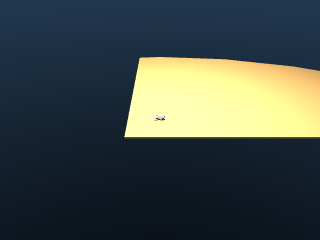

""

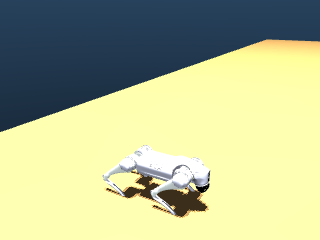

""

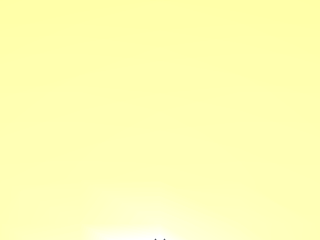

""

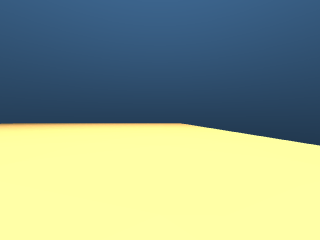

INFO:2025-11-10 09:51:01,042:jax._src.xla_bridge:924: Unable to initialize backend 'rocm': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
INFO:jax._src.xla_bridge:Unable to initialize backend 'rocm': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
INFO:2025-11-10 09:51:01,076:jax._src.xla_bridge:924: Unable to initialize backend 'tpu': INTERNAL: Failed to open libtpu.so: libtpu.so: cannot open shared object file: No such file or directory
INFO:jax._src.xla_bridge:Unable to initialize backend 'tpu': INTERNAL: Failed to open libtpu.so: libtpu.so: cannot open shared object file: No such file or directory
INFO:root:Using JAX default device: cuda:0.
INFO:root:MJX Warp is disabled via MJX_WARP_ENABLED=false.
INFO:root:Using JAX default device: cuda:0.
INFO:root:MJX Warp is disabled via MJX_WARP_ENABLED=false.
INFO:root:Using JAX default device: cuda:0.
INFO:root:MJX Warp is disabled via MJX_WARP_ENABLED=false.


Setup finished, initializing the environment...


INFO:root:Using JAX default device: cuda:0.
INFO:root:MJX Warp is disabled via MJX_WARP_ENABLED=false.


TypeError: unsupported operand type(s) for *: 'list' and 'BatchTracer'

In [1]:
#@title Setup Session

# Configure logging
import logging
logging.basicConfig(level=logging.INFO, force=True)
logging.info("Logging switched on.")

import os
# Ensure that Madrona gets the chance to pre-allocate memory before Jax
os.environ["XLA_PYTHON_CLIENT_PREALLOCATE"] = "false"

# On your second reading, load the compiled rendering backend to save time!
use_madrona_cache = False #@param {"type":"boolean"}
if use_madrona_cache:
    os.environ["MADRONA_MWGPU_KERNEL_CACHE"] = "modules/madrona_mjx/build/cache"

# Add an ICD config so that glvnd can pick up the Nvidia EGL driver.
# This is usually installed as part of an Nvidia driver package, but the Colab
# kernel doesn't install its driver via APT, and as a result the ICD is missing.
# (https://github.com/NVIDIA/libglvnd/blob/master/src/EGL/icd_enumeration.md)
NVIDIA_ICD_CONFIG_PATH = '/usr/share/glvnd/egl_vendor.d/10_nvidia.json'
if not os.path.exists(NVIDIA_ICD_CONFIG_PATH):
    with open(NVIDIA_ICD_CONFIG_PATH, 'w') as f:
        f.write("""{
        "file_format_version" : "1.0.0",
        "ICD" : {
            "library_path" : "libEGL_nvidia.so.0"
        }
    }
    """)

# Configure MuJoCo to use the EGL rendering backend (requires GPU)
print('Setting environment variable to use GPU rendering:')
%env MUJOCO_GL=egl

# Tell XLA to use Triton GEMM, this improves steps/sec by ~30% on some GPUs
xla_flags = os.environ.get('XLA_FLAGS', '')
xla_flags += ' --xla_gpu_triton_gemm_any=True'
os.environ['XLA_FLAGS'] = xla_flags

# More legible printing from numpy.
import numpy as np
np.set_printoptions(precision=3, suppress=True, linewidth=100)

# Prepare paths
from pathlib import Path
repo_path = Path("unitree-go2-mjx-rl")
robot_name = "unitree_go2"
scenes_path = repo_path / "resources" / robot_name
results_path = Path("results")
results_path.mkdir(parents=True, exist_ok=True)

# Relevant imports
import functools
import jax
from jax import numpy as jnp

# Prepare robot config
from quadruped_mjx_rl.robots import predefined_robot_configs
robot_config = predefined_robot_configs[robot_name]()

# Prepare env config
from quadruped_mjx_rl.environments import QuadrupedVisionBaseEnvConfig
CameraConfig = QuadrupedVisionBaseEnvConfig.ObservationConfig.CameraInputConfig
env_config = QuadrupedVisionBaseEnvConfig(
    observation_noise=QuadrupedVisionBaseEnvConfig.ObservationConfig(
        camera_inputs=[
            CameraConfig("frontal_ego", True, True, True),
            CameraConfig("terrain", True, True, True),
        ]
    )
)

# Prepare scene file
init_scene_path = scenes_path / "scene_mjx_empty_arena.xml"

# Prepare the terrain
from quadruped_mjx_rl.terrain_gen import make_plain_tiled_terrain
env_model = make_plain_tiled_terrain(init_scene_path)

# Render the environments from different cameras in mujoco
from quadruped_mjx_rl.environments.rendering import (
    render_model,
    show_image,
    large_overview_camera,
)
render_cam = functools.partial(
    render_model, env_model=env_model, initial_keyframe=robot_config.initial_keyframe
)
image_overview = render_cam(camera=large_overview_camera())
image_tracking = render_cam(camera="track")
image_terrain = render_cam(camera="privileged")
image_egocentric = render_cam(camera="ego_frontal")
show_image(image_overview)
show_image(image_tracking)
show_image(image_terrain)
show_image(image_egocentric)

# Prepare vision config
from quadruped_mjx_rl.robotic_vision import VisionConfig
num_envs=64 #@param {"type":"integer"}
enabled_cameras=[1, 2] #@param
enabled_geom_groups=[0, 1, 2] #@param
render_width=64 #@param {"type":"integer"}
render_height=64 #@param {"type":"integer"}
vision_config = VisionConfig(
    render_batch_size=num_envs,
    enabled_cameras=enabled_cameras,
    enabled_geom_groups=enabled_geom_groups,
    render_width=render_width,
    render_height=render_height,
)

# Make the env factory
from quadruped_mjx_rl.environments import get_env_factory
from quadruped_mjx_rl.robotic_vision import get_renderer
renderer_maker = functools.partial(get_renderer, vision_config=vision_config, debug=False)
env_factory = get_env_factory(
    robot_config=robot_config,
    environment_config=env_config,
    env_model=env_model,
    customize_model=True,
    vision_config=vision_config,
    renderer_maker=renderer_maker,
)

# Execute one environment step to initialize mjx
from mujoco import mjx
mjx_model = mjx.put_model(env_model)
mjx_data = mjx.make_data(mjx_model)
mjx_data = mjx.forward(mjx_model, mjx_data)

# Create the environment
print("Setup finished, initializing the environment...")
env = env_factory()

# Wrap the environment
from quadruped_mjx_rl.environments.wrappers import wrap_for_training
env = wrap_for_training(
    env=env,
    vision=True,
    num_vision_envs=num_envs,
)
jit_reset = jax.jit(env.reset)
jit_step = jax.jit(env.step)

# Execute one step
state = jit_reset(jax.random.split(jax.random.PRNGKey(0), num_envs))
state = jit_step(state, jnp.zeros((num_envs, env.action_size)))

In [ ]:
frontal_view = state.obs["pixels/frontal_ego/rgb"]
print(frontal_view.shape)
terrain_view = state.obs["pixels/terrain/rgb"]
print(terrain_view.shape)

In [ ]:
def tile(img, d):
    assert img.shape[0] == d*d
    img = img.reshape((d,d)+img.shape[1:])
    return np.concat(np.concat(img, axis=1), axis=1)  # replace with 2 for multi-camera tensors!

# image = tile(rgb_tensor[:16], 4)
# image.shape
frontal_view_image = tile(frontal_view[:16], 4)
print(frontal_view_image.shape)
terrain_view_image = tile(terrain_view[:16], 4)
print(terrain_view_image.shape)

In [ ]:
media.show_image(frontal_view_image, width=512)

In [ ]:
media.show_image(terrain_view_image, width=512)